## 自己組織化マップ（SOM)＆クラスタリング 2

絵画に使われている色を、先に作った自己組織化マップのプログラムで解析している。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook
import urllib.request
import io
import PIL.Image
import cv2

# ネット上の画像を取ってくるメソッド
def url2img(url):
    print(url)
    f = io.BytesIO(urllib.request.urlopen(url).read())
    img = PIL.Image.open(f)
    imgArray = np.asarray(img)
    return imgArray

# 画像から　色を　num 個ピックアップするメソッド
def pickcolor(imgArray, num):
    w = imgArray.shape[1]
    h = imgArray.shape[0]
    ret = []
    for i in range(num):
        rw = int(w*np.random.rand())
        rh = int(h*np.random.rand())
        ret.append(imgArray[rh,rw]/255)
    return ret

In [2]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize))
    mini, minj = get_winner(M,x)
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,3),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    for i in range(-ksize,ksize+1): #  勝者の近傍7x7 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-ksize,ksize+1):
            try:
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

def show_som(M):
    im = plt.imshow(M,interpolation='nearest',origin='lower')
    return im

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj

# 配列３次元M（ただし最後の次元は３要素でありカラーデータとみなせるもの）を matplot 画像データとして返す
def show_som(M):
    im = plt.imshow(M,interpolation='none',origin='lower')
    return im

In [3]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

from matplotlib.colors import LinearSegmentedColormap
# カスタムカラーマップの生成
def generate_cmap(centers):
    lebels = len(centers)
    values = range(lebels)
    color_list = centers # ３次元データの重心の値そのものをカラーデータとみなす
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

# 境界の描画
def plotBoundary(labels, somcenters, cmap='tab20', colorbar=True):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
    
    if colorbar:
        plt.colorbar()
        
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

ウェブ上の画像をカラーデータの採取用に読み込む

http://bokyo-qualia.com/wp-content/uploads/2013/10/glass-gem-corn-rainbow-colored-10_s.jpg


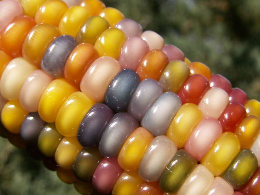

In [4]:
# 信じられないほどカラフルなトウモロコシ　グラスジェムコーン
imgArray = url2img("http://bokyo-qualia.com/wp-content/uploads/2013/10/glass-gem-corn-rainbow-colored-10_s.jpg")
img = PIL.Image.fromarray(imgArray)
img.resize(np.array(img.size)//2)

<IPython.core.display.Javascript object>


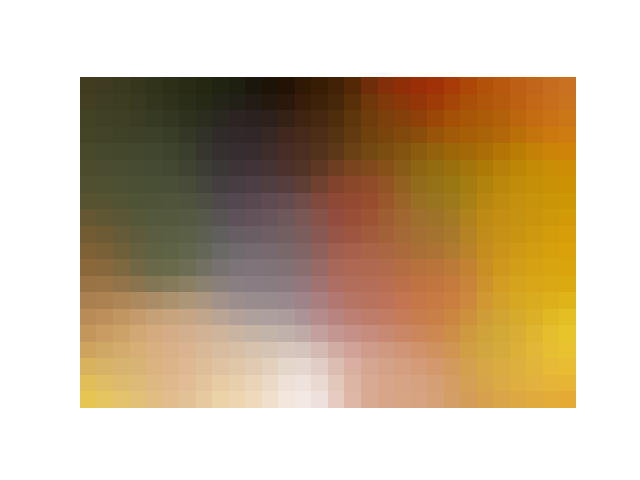

In [5]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 256 # 繰り返し学習回数
batchsize = 128 # １回の繰り返しで採取するデータの数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,3]) # Map 用の配列

fig = plt.figure()
plt.axis('off')
ims = []

for time in range(learntime):
    pcolors = pickcolor(imgArray,batchsize)  # ランダムにbatchsize色ピックアップ
    for color in pcolors:
        W=organize_som(W, color,alpha=alpha,ksize=3) # 競合学習の実行
    ims.append([show_som(W)])  
            
ani = animation.ArtistAnimation(fig, ims , repeat=False)
plt.show()
plt.savefig( 'M-0.jpg' )

[(11, 26), (17, 19), (16, 24), (14, 2), (6, 19), (4, 4), (11, 19), (19, 4), (2, 10), (6, 13), (11, 12), (3, 26)]


<IPython.core.display.Javascript object>


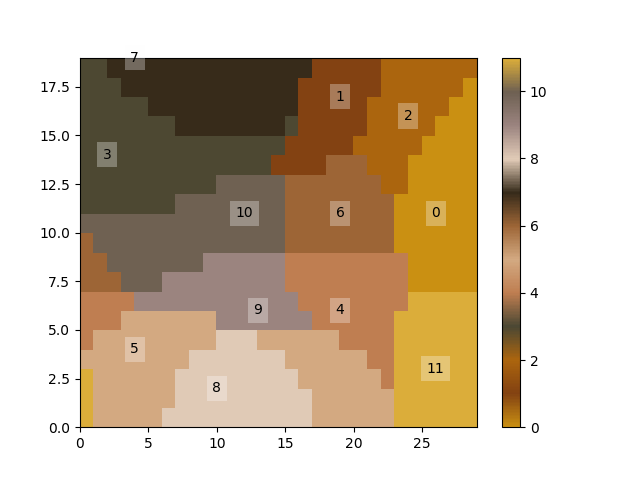

In [6]:
# 代表色12
labelimage, centers = kmeans(W,12,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)
plt.savefig( '0-1.jpg' )

[(13, 24), (11, 15), (17, 27), (13, 5), (5, 21), (2, 21), (8, 24), (17, 11), (4, 7), (6, 8), (9, 12), (9, 28), (1, 2), (17, 20), (10, 19), (7, 16), (3, 26), (16, 23), (9, 4), (17, 16), (2, 12), (17, 3), (6, 27), (12, 27)]


<IPython.core.display.Javascript object>


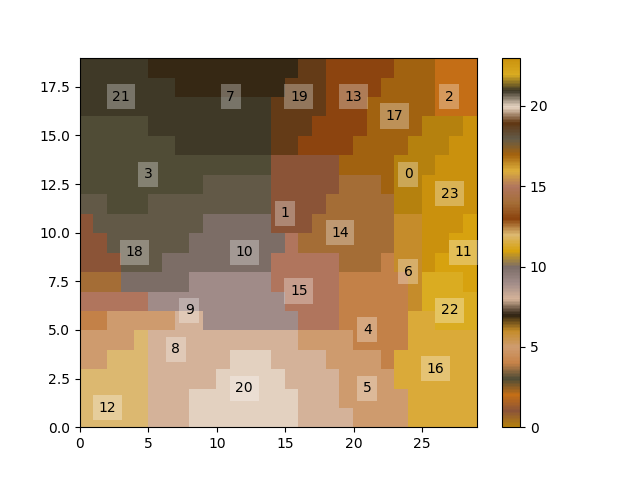

In [7]:
# 代表色24
labelimage, centers = kmeans(W,24,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)
plt.savefig( '0-2.jpg' )

[(13, 25), (14, 18), (18, 27), (15, 2), (5, 22), (1, 24), (11, 23), (18, 10), (2, 10), (5, 14), (10, 0), (9, 28), (1, 1), (18, 20), (8, 22), (6, 19), (3, 27), (17, 23), (12, 3), (17, 17), (1, 14), (15, 14), (7, 27), (10, 25), (10, 19), (17, 3), (14, 9), (3, 7), (7, 9), (6, 3), (13, 11), (11, 12), (4, 1), (8, 13), (5, 17), (12, 20), (1, 4), (14, 23), (17, 14), (16, 28), (10, 6), (5, 24), (13, 28), (4, 13), (2, 19), (11, 15), (8, 16), (17, 7)]


<IPython.core.display.Javascript object>


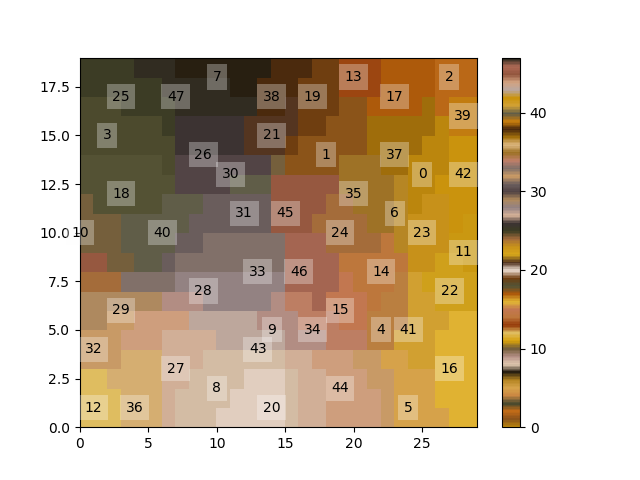

In [8]:
# 代表色48
labelimage, centers = kmeans(W,48,100)
somcenters = [get_winner(W,c)  for c in centers]
print(somcenters)
custom_cmap = generate_cmap(centers)
plotBoundary(labelimage, somcenters, cmap=custom_cmap)
plt.savefig( '0-3.jpg' )

In [ ]:
img.size